In [220]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_squared_error

In [221]:
input_df = pd.read_csv("data/input_data_nn.csv", sep=";")
output_df = pd.read_csv("data/output_data_nn.csv", sep=";")

In [222]:
df = pd.concat([input_df, output_df], axis=1)

In [223]:
cols = output_df.columns.tolist() + input_df.columns.tolist()

In [224]:
cols = [ 'pot_ativa_inj_barramento11','tensao_barramento11',
 'tensao_barramento12',
 'tensao_barramento24',
 'pot_ativa_inj_barramento12',
 'pot_ativa_inj_barramento24',
 'pot_reativa_inj_barramento11',
 'pot_reativa_inj_barramento12',
 'pot_reativa_inj_barramento24',
 'carga_subrede_138kv',
 'pot_eolica_subrede_138kv',
 'pot_solar_subrede_138kv',
 'status_1_gerador_subrede_230kv',
 'status_2_gerador_subrede_230kv',
 'status_3_gerador_subrede_230kv',
 'status_4_gerador_subrede_230kv',
 'status_5_gerador_subrede_230kv',
 'status_6_gerador_subrede_230kv',
 'status_7_gerador_subrede_230kv',
 'status_8_gerador_subrede_230kv',
 'status_9_gerador_subrede_230kv',
 'status_10_gerador_subrede_230kv',
 'status_11_gerador_subrede_230kv',
 'status_12_gerador_subrede_230kv',
 'status_13_gerador_subrede_230kv',
 'status_14_gerador_subrede_230kv',
 'status_15_gerador_subrede_230kv',
 'status_16_gerador_subrede_230kv',
 'status_17_gerador_subrede_230kv',
 'status_18_gerador_subrede_230kv',
 'status_1_linha_subrede_230kv',
 'status_2_linha_subrede_230kv',
 'status_3_linha_subrede_230kv',
 'status_4_linha_subrede_230kv',
 'status_5_linha_subrede_230kv',
 'status_6_linha_subrede_230kv',
 'status_7_linha_subrede_230kv',
 'status_8_linha_subrede_230kv',
 'status_9_linha_subrede_230kv',
 'status_10_linha_subrede_230kv',
 'status_11_linha_subrede_230kv',
 'status_12_linha_subrede_230kv',
 'status_13_linha_subrede_230kv',
 'status_14_linha_subrede_230kv',
 'status_15_linha_subrede_230kv',
 'status_16_linha_subrede_230kv',
 'status_17_linha_subrede_230kv',
 'status_18_linha_subrede_230kv',
 'status_19_linha_subrede_230kv',
 'status_20_linha_subrede_230kv',
 'status_21_linha_subrede_230kv']

In [225]:
df = df[cols]

In [226]:
test_split=round(len(df)*0.30)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(6132, 51)
(2628, 51)


In [227]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled

array([[2.23414479e-01, 8.85093517e-01, 9.06639273e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.40612011e-02, 5.79535979e-01, 6.06571508e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.20553071e-02, 5.93556780e-01, 6.15978314e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.80782404e-01, 5.90426301e-01, 6.10941843e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.69935018e-01, 8.04570513e-06, 1.28604370e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.71499171e-01, 8.02700704e-06, 4.03680547e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [228]:
days = 30
max_idx_pred = 1

In [229]:
def createXY(dataset, max_idx_pred, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i, 0:max_idx_pred])
    return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled, max_idx_pred, 24 * days)
testX,testY=createXY(df_for_testing_scaled, max_idx_pred, 24 * days)

print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

trainX Shape--  (5412, 720, 51)
trainY Shape--  (5412, 1)
testX Shape--  (1908, 720, 51)
testY Shape--  (1908, 1)


In [272]:
def build_model():
    grid_model = Sequential()
    grid_model.add(LSTM(100, return_sequences = True, input_shape=(24 * days, trainX.shape[-1])))
    grid_model.add(LSTM(70, return_sequences = True))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(max_idx_pred))

    grid_model.compile(loss = 'mse',optimizer = 'adam')
    grid_model.fit(trainX,trainY, batch_size = 32, epochs = 10, validation_data = (testX, testY))
    
    return grid_model

model = build_model()

Epoch 1/10
170/170 [==============================] - 145s 837ms/step - loss: 0.0304 - val_loss: 0.0166
Epoch 2/10
170/170 [==============================] - 180s 1s/step - loss: 0.0149 - val_loss: 0.0129
Epoch 3/10
170/170 [==============================] - 197s 1s/step - loss: 0.0109 - val_loss: 0.0084
Epoch 4/10
170/170 [==============================] - 148s 868ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 5/10
170/170 [==============================] - 150s 884ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 6/10
170/170 [==============================] - 183s 1s/step - loss: 0.0057 - val_loss: 0.0043
Epoch 7/10
170/170 [==============================] - 156s 919ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 8/10
170/170 [==============================] - 148s 873ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 9/10
170/170 [==============================] - 164s 965ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 10/10
170/170 [==============================] - 143s 843ms/step - 

In [273]:
prediction=model.predict(testX)

In [248]:
def inverse_transform(arrs):
    zeros_padding = np.zeros(testX.shape[-1] - (max_idx_pred))
    arrs_copies = list(map(lambda arr: np.concatenate((arr, zeros_padding)), arrs))
    return scaler.inverse_transform(np.reshape(arrs_copies, (len(arrs), testX.shape[-1])))
#[:,1]

In [249]:
prediction

array([[0.7094626 ],
       [0.65723354],
       [0.5545563 ],
       ...,
       [0.6903777 ],
       [0.5276888 ],
       [0.41469473]], dtype=float32)

In [274]:
pred = inverse_transform(prediction)
originals = inverse_transform(testY)

In [275]:
print("pred pot_ativa_inj_barramento11: " + str(pred[:,0]))
print("original pot_ativa_inj_barramento11: " + str(originals[:,0]))
print()

pred pot_ativa_inj_barramento11: [80.66866087 76.12598393 64.74770117 ... 83.68114266 61.1943706
 50.86623389]
original pot_ativa_inj_barramento11: [82.10234537 65.22998349 82.06396348 ... 72.60335738 57.87360805
 56.83372024]



In [166]:
print("pred tensao_barramento11: " + str(pred[:,0]))
print("original tensao_barramento11: " + str(originals[:,0]))
print()
print("pred tensao_barramento12: " + str(pred[:,1]))
print("original tensao_barramento12: " + str(originals[:,1]))
print()
print("pred tensao_barramento24: " + str(pred[:,2]))
print("original tensao_barramento24: " + str(originals[:,2]))
print()
print("pred tensao_barramento24: " + str(pred[:,2]))
print("original tensao_barramento24: " + str(originals[:,2]))
print()
print("pred pot_ativa_inj_barramento11: " + str(pred[:,3]))
print("original pot_ativa_inj_barramento11: " + str(originals[:,3]))
print()

pred tensao_barramento11: [1.01334414 0.99277805 0.99481454 ... 1.01292363 0.9870933  0.94952426]
original tensao_barramento11: [1.00269358 1.00453829 1.00513947 ... 1.0019635  0.95127084 0.95126964]

pred tensao_barramento12: [1.01235144 0.99268041 0.99489139 ... 1.01326569 0.98885    0.94981958]
original tensao_barramento12: [0.99990073 1.00272539 1.00364593 ... 1.00335917 0.95157989 0.95158083]

pred tensao_barramento24: [1.00026255 0.97675341 0.97980152 ... 1.00912616 0.98568991 0.9514155 ]
original tensao_barramento24: [0.98334365 0.98592246 0.98566991 ... 1.00685737 0.95000062 0.95000064]

pred tensao_barramento24: [1.00026255 0.97675341 0.97980152 ... 1.00912616 0.98568991 0.9514155 ]
original tensao_barramento24: [0.98334365 0.98592246 0.98566991 ... 1.00685737 0.95000062 0.95000064]

pred pot_ativa_inj_barramento11: [77.61293781 60.00705901 49.46027855 ... 85.50988677 61.05178586
 53.62100092]
original pot_ativa_inj_barramento11: [66.24799586 54.39864737 48.00403871 ... 72.603

In [135]:
def rmse(index):
    plt.plot(originals[:,index], color = 'red', label = 'Real Stock Price')
    plt.plot(pred[:,index], color = 'blue', label = 'Predicted Stock Price')
    plt.legend()
    plt.show()
    return sqrt(mean_squared_error(originals[:,index], pred[:,index]))

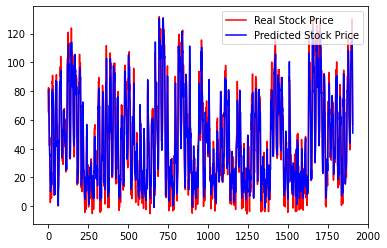

9.325352244841719

In [278]:
rmse(0)

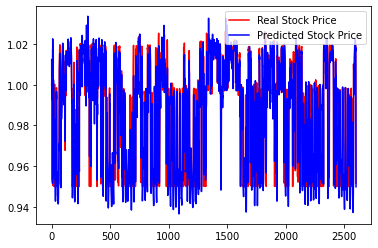

0.013373565296075715

In [168]:
rmse(1)

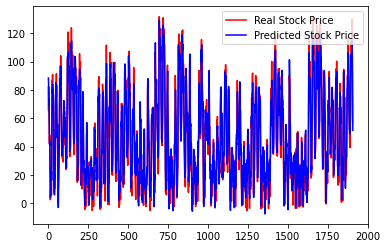

10.067710098313567

In [264]:
rmse(0)

## Grid search

In [163]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,51)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    # {'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}
    grid_model.fit(trainX,trainY, batch_size =  16, epochs = 10,validation_data=(testX, testY))
    
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)


grid_search = grid_search.fit(trainX,trainY)
grid_search.best_params_
my_model=grid_search.best_estimator_.model

/tmp/ipykernel_10384/1044546172.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))


In [305]:
prediction_copies_array = np.repeat(prediction, 25, axis=1)
prediction_copies_array_m = list(map(lambda pred: (pred.tolist() * 25) + [pred.tolist()[0]], prediction))
pred = scaler.inverse_transform(np.reshape(prediction_copies_array_m,(len(prediction),51)))[:,1]